# Análisis K-Means: Congestión en Santiago

## Objetivo
Aplicar el algoritmo K-Means para identificar patrones de congestión vehicular en Santiago.

## Puntos clave:
1. Preparar los datos (escalar)
2. Identificar número óptimo de clústers (elbow, silhouette, gap)
3. Implementar K-Means con k óptimo
4. Visualizar e interpretar resultados

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

# Librerías para clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Configuración de visualización
plt.style.use('default')
sns.set_theme(style='darkgrid', palette='husl')
%matplotlib inline

print('✓ Librerías importadas correctamente')

✓ Librerías importadas correctamente


In [2]:
# Cargar datos
df = pd.read_csv('../data/congestion-1.csv')
print(f'Datos cargados: {df.shape[0]} filas x {df.shape[1]} columnas')
df.head()

Datos cargados: 76140 filas x 70 columnas


,Latitud,Longitud,Fecha,Duration_hrs,Length_km,Speed_km/h,Peak_Time,Commune,Street,Hora Inicio,...,Commune_Tiltil,Commune_Vitacura,Commune_Ñuñoa,Dia_Semana_0.0,Dia_Semana_1.0,Dia_Semana_2.0,Dia_Semana_3.0,Dia_Semana_4.0,Dia_Semana_5.0,Dia_Semana_6.0
0,-33.645078,-70.574046,2025-05-23,0.42,0.98,12.54,6.916667,Pirque,Camino Carlos Vial Infante,6.916667,...,0,0,0,0,0,0,0,1,0,0
1,-33.835065,-70.848198,2025-05-23,0.42,0.95,18.81,17.500000,Paine,NaN,17.500000,...,0,0,0,0,0,0,0,1,0,0
2,-33.426014,-70.614984,2025-05-23,0.42,0.86,24.00,13.333333,Providencia,Av. Nueva Providencia,13.250000,...,0,0,0,0,0,0,0,1,0,0
3,-33.430052,-70.583705,2025-05-23,0.42,0.83,20.10,8.166667,Las Condes,Isabel La Católica,7.916667,...,0,0,0,0,0,0,0,1,0,0
4,-33.626836,-70.628575,2025-05-23,0.33,1.03,14.93,11.750000,La Pintana,Los Álamos,11.666667,...,0,0,0,0,0,0,0,1,0,0


## 2. Exploración inicial de datos

In [3]:
# Información general
print('=== INFORMACIÓN DEL DATASET ===')
print(f'\nDimensiones: {df.shape}')
print(f'\nValores nulos por columna:')
print(df.isnull().sum()[df.isnull().sum() > 0])
print(f'\nTipos de datos:')
print(df.dtypes.value_counts())

=== INFORMACIÓN DEL DATASET ===

Dimensiones: (76140, 70)

Valores nulos por columna:
Fecha     6023
Street     734
dtype: int64

Tipos de datos:
int64      59
float64     8
object      3
Name: count, dtype: int64


In [4]:
# Estadísticas descriptivas de variables numéricas clave
variables_clave = ['Duration_hrs', 'Length_km', 'Speed_km/h', 'Peak_Time', 'Hora Inicio', 'Hora Fin']
df[variables_clave].describe()

,Duration_hrs,Length_km,Speed_km/h,Peak_Time,Hora Inicio,Hora Fin
count,76140.000000,76140.000000,76140.000000,76140.000000,76140.000000,76140.000000
mean,0.843636,0.396654,17.738924,13.710889,13.475617,14.319463
std,0.978062,0.283178,4.530798,4.403144,4.388877,4.470866
min,0.250000,0.100000,0.080000,6.083333,6.083333,6.333333
25%,0.330000,0.230000,14.630000,8.500000,8.333333,9.166667
50%,0.500000,0.320000,18.080000,14.166667,14.000000,14.833333
75%,0.920000,0.460000,21.440000,17.916667,17.666667,18.666667
max,10.000000,11.830000,25.000000,23.333333,20.916667,23.916667


## 3. Preparación de datos

In [5]:
# Seleccionar variables numéricas para clustering
# Excluimos variables categóricas originales y nos quedamos con las one-hot encoded
variables_numericas = df.select_dtypes(include=[np.number]).columns.tolist()

# Crear dataset para clustering
df_clustering = df[variables_numericas].copy()

# Eliminar filas con valores nulos si existen
df_clustering = df_clustering.dropna()

print(f'Variables seleccionadas para clustering: {len(df_clustering.columns)}')
print(f'Registros válidos: {len(df_clustering)}')
print(f'\nPrimeras variables: {df_clustering.columns[:10].tolist()}')

Variables seleccionadas para clustering: 67
Registros válidos: 76140

Primeras variables: ['Latitud', 'Longitud', 'Duration_hrs', 'Length_km', 'Speed_km/h', 'Peak_Time', 'Hora Inicio', 'Hora Fin', 'Commune_Alhué', 'Commune_Buin']


In [6]:
# ESCALADO DE DATOS (StandardScaler)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)

print('✓ Datos escalados correctamente')
print(f'Shape de datos escalados: {df_scaled.shape}')
print(f'\nMedia de variables escaladas (debe ser ~0): {df_scaled.mean():.6f}')
print(f'Desviación estándar (debe ser ~1): {df_scaled.std():.6f}')

✓ Datos escalados correctamente
Shape de datos escalados: (76140, 67)

Media de variables escaladas (debe ser ~0): -0.000000
Desviación estándar (debe ser ~1): 1.000000


## 4. Determinar número óptimo de clusters

### 4.1 Método del Codo (Elbow Method)

K=2: Inercia=4911564.17
K=3: Inercia=4806997.87
K=4: Inercia=4719572.56
K=5: Inercia=4649366.40
K=6: Inercia=4567737.82
K=7: Inercia=4491791.13
K=8: Inercia=4428181.17
K=9: Inercia=4339587.93
K=10: Inercia=4262682.35


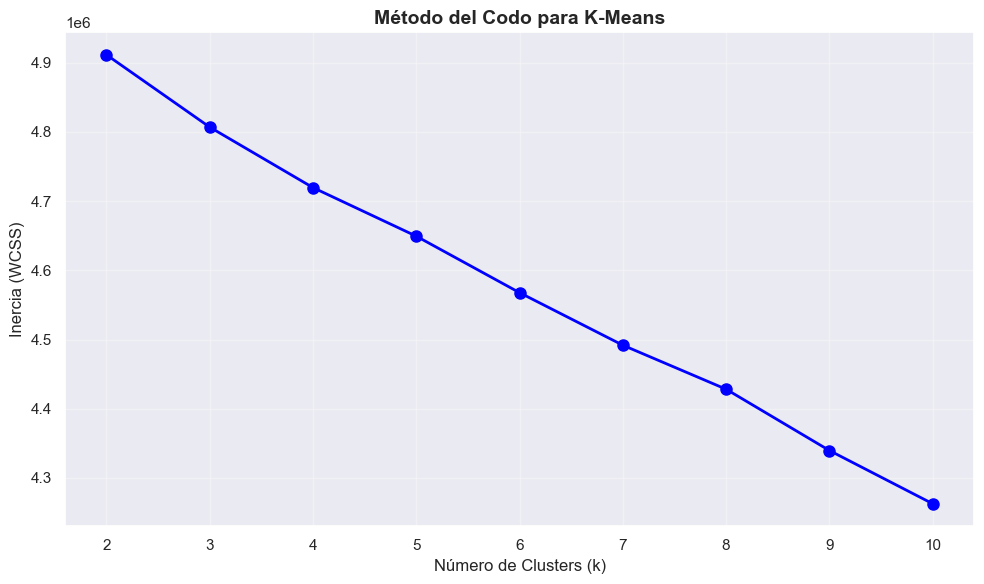


💡 Buscar el "codo" donde la inercia deja de disminuir significativamente


In [7]:
# Método del Codo
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)
    print(f'K={k}: Inercia={kmeans.inertia_:.2f}')

# Visualización
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inercia (WCSS)', fontsize=12)
plt.title('Método del Codo para K-Means', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.tight_layout()
plt.show()

print('\n💡 Buscar el "codo" donde la inercia deja de disminuir significativamente')

### 4.2 Método de Silhouette

K=2: Silhouette Score=0.0479
K=3: Silhouette Score=0.0485
K=4: Silhouette Score=0.0569
K=5: Silhouette Score=0.0657
K=6: Silhouette Score=0.0766
K=7: Silhouette Score=0.0876
K=8: Silhouette Score=0.0216
K=9: Silhouette Score=-0.0055
K=10: Silhouette Score=0.0510


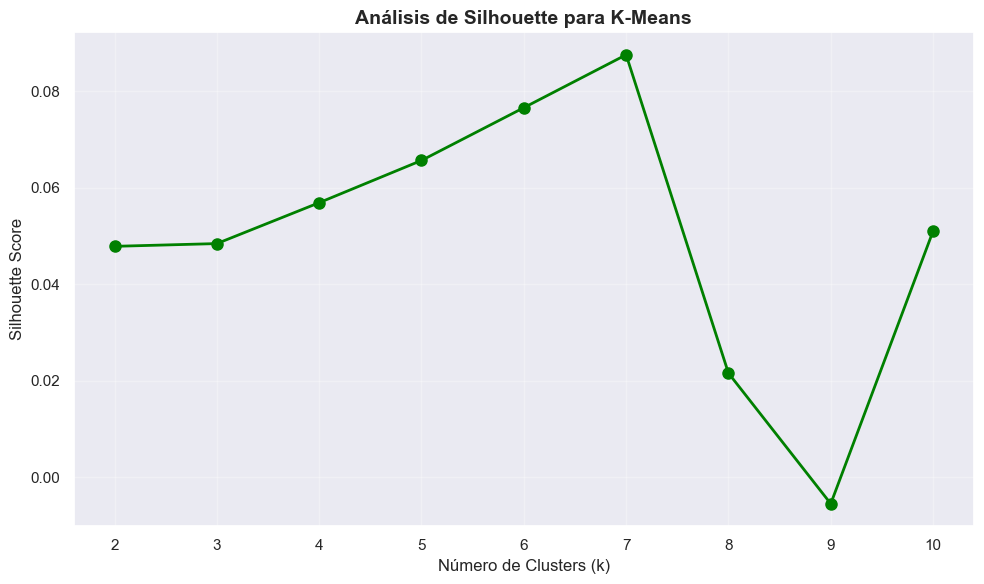


✓ K óptimo según Silhouette: 7 (Score: 0.0876)


In [8]:
# Método de Silhouette
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, labels)
    silhouette_scores.append(score)
    print(f'K={k}: Silhouette Score={score:.4f}')

# Visualización
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Análisis de Silhouette para K-Means', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.tight_layout()
plt.show()

k_optimo_silhouette = K_range[np.argmax(silhouette_scores)]
print(f'\n✓ K óptimo según Silhouette: {k_optimo_silhouette} (Score: {max(silhouette_scores):.4f})')

### 4.3 Método Gap Statistic

Calculando Gap Statistic (puede tomar unos minutos)...

K=2: Gap=8.1679 ± 0.0002
K=3: Gap=8.1824 ± 0.0005
K=4: Gap=8.1953 ± 0.0003
K=5: Gap=8.2061 ± 0.0004
K=6: Gap=8.2200 ± 0.0004
K=7: Gap=8.2335 ± 0.0004
K=8: Gap=8.2445 ± 0.0004
K=9: Gap=8.2622 ± 0.0004
K=10: Gap=8.2774 ± 0.0003


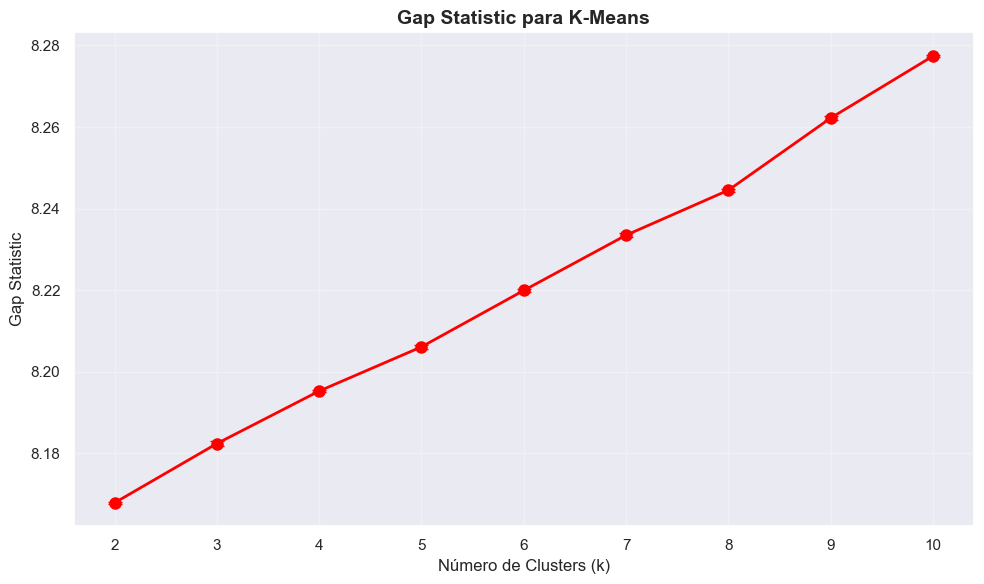


✓ K óptimo según Gap Statistic: 10 (Gap: 8.2774)


In [9]:
# Implementación del Gap Statistic
def gap_statistic(data, k_range, n_refs=10, random_state=42):
    """
    Calcula el Gap Statistic para determinar el número óptimo de clusters.
    """
    gaps = []
    std_gaps = []
    
    for k in k_range:
        # Clustering en datos reales
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        kmeans.fit(data)
        real_dispersion = np.log(kmeans.inertia_)
        
        # Clustering en datos de referencia (random)
        ref_dispersions = []
        for _ in range(n_refs):
            random_data = np.random.uniform(data.min(), data.max(), size=data.shape)
            kmeans_ref = KMeans(n_clusters=k, random_state=random_state, n_init=10)
            kmeans_ref.fit(random_data)
            ref_dispersions.append(np.log(kmeans_ref.inertia_))
        
        # Calcular gap
        gap = np.mean(ref_dispersions) - real_dispersion
        std_gap = np.std(ref_dispersions)
        
        gaps.append(gap)
        std_gaps.append(std_gap)
        
        print(f'K={k}: Gap={gap:.4f} ± {std_gap:.4f}')
    
    return gaps, std_gaps

# Calcular Gap Statistic
print('Calculando Gap Statistic (puede tomar unos minutos)...\n')
gaps, std_gaps = gap_statistic(df_scaled, K_range, n_refs=10)

# Visualización
plt.figure(figsize=(10, 6))
plt.errorbar(K_range, gaps, yerr=std_gaps, fmt='ro-', linewidth=2, markersize=8, capsize=5)
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Gap Statistic', fontsize=12)
plt.title('Gap Statistic para K-Means', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.tight_layout()
plt.show()

k_optimo_gap = K_range[np.argmax(gaps)]
print(f'\n✓ K óptimo según Gap Statistic: {k_optimo_gap} (Gap: {max(gaps):.4f})')

### 4.4 Resumen de métodos de selección de K

In [10]:
# Resumen comparativo
print('='*60)
print('RESUMEN: NÚMERO ÓPTIMO DE CLUSTERS')
print('='*60)
print(f'Método del Codo: Revisar gráfico manualmente')
print(f'Método Silhouette: K = {k_optimo_silhouette}')
print(f'Método Gap Statistic: K = {k_optimo_gap}')
print('='*60)

# Seleccionar K óptimo (usaremos el de Silhouette como referencia)
K_OPTIMO = k_optimo_silhouette
print(f'\n✓ K SELECCIONADO PARA EL ANÁLISIS: {K_OPTIMO}')
print('\n💡 Nota: Puedes cambiar K_OPTIMO manualmente si lo consideras necesario')

RESUMEN: NÚMERO ÓPTIMO DE CLUSTERS
Método del Codo: Revisar gráfico manualmente
Método Silhouette: K = 7
Método Gap Statistic: K = 10

✓ K SELECCIONADO PARA EL ANÁLISIS: 7

💡 Nota: Puedes cambiar K_OPTIMO manualmente si lo consideras necesario


In [11]:
# Entrenar modelo final
kmeans_final = KMeans(n_clusters=K_OPTIMO, random_state=42, n_init=20)
clusters = kmeans_final.fit_predict(df_scaled)

# Agregar clusters al dataframe original
df_resultado = df.copy()
df_resultado['Cluster'] = clusters

# Métricas del modelo
silhouette_final = silhouette_score(df_scaled, clusters)
print('='*60)
print('MODELO K-MEANS FINAL')
print('='*60)
print(f'Número de clusters: {K_OPTIMO}')
print(f'Silhouette Score: {silhouette_final:.4f}')
print(f'Inercia: {kmeans_final.inertia_:.2f}')
print('='*60)

# Distribución de clusters
print('\nDistribución de observaciones por cluster:')
print(df_resultado['Cluster'].value_counts().sort_index())
print(f'\nPorcentaje por cluster:')
print((df_resultado['Cluster'].value_counts(normalize=True).sort_index() * 100).round(2))

MODELO K-MEANS FINAL
Número de clusters: 7
Silhouette Score: 0.0876
Inercia: 4491791.13

Distribución de observaciones por cluster:
Cluster
0    35829
1    25004
2     4967
3     5453
4     1784
5     1573
6     1530
Name: count, dtype: int64

Porcentaje por cluster:
Cluster
0    47.06
1    32.84
2     6.52
3     7.16
4     2.34
5     2.07
6     2.01
Name: proportion, dtype: float64


## 5. Implementar K-Means con K óptimo

In [12]:
# Guardar resultados
df_resultado.to_csv('../resultados/resultados_kmeans.csv', index=False)
print('✓ Resultados exportados a: ../resultados/resultados_kmeans.csv')

# Guardar centroides
centroides = pd.DataFrame(scaler.inverse_transform(kmeans_final.cluster_centers_), 
                          columns=df_clustering.columns)
centroides.to_csv('../resultados/centroides_clusters.csv', index=False)
print('✓ Centroides exportados a: ../resultados/centroides_clusters.csv')

✓ Resultados exportados a: ../resultados/resultados_kmeans.csv
✓ Centroides exportados a: ../resultados/centroides_clusters.csv


## 6. Visualización e Interpretación de Resultados

### 6.1 Boxplots de variables clave por cluster

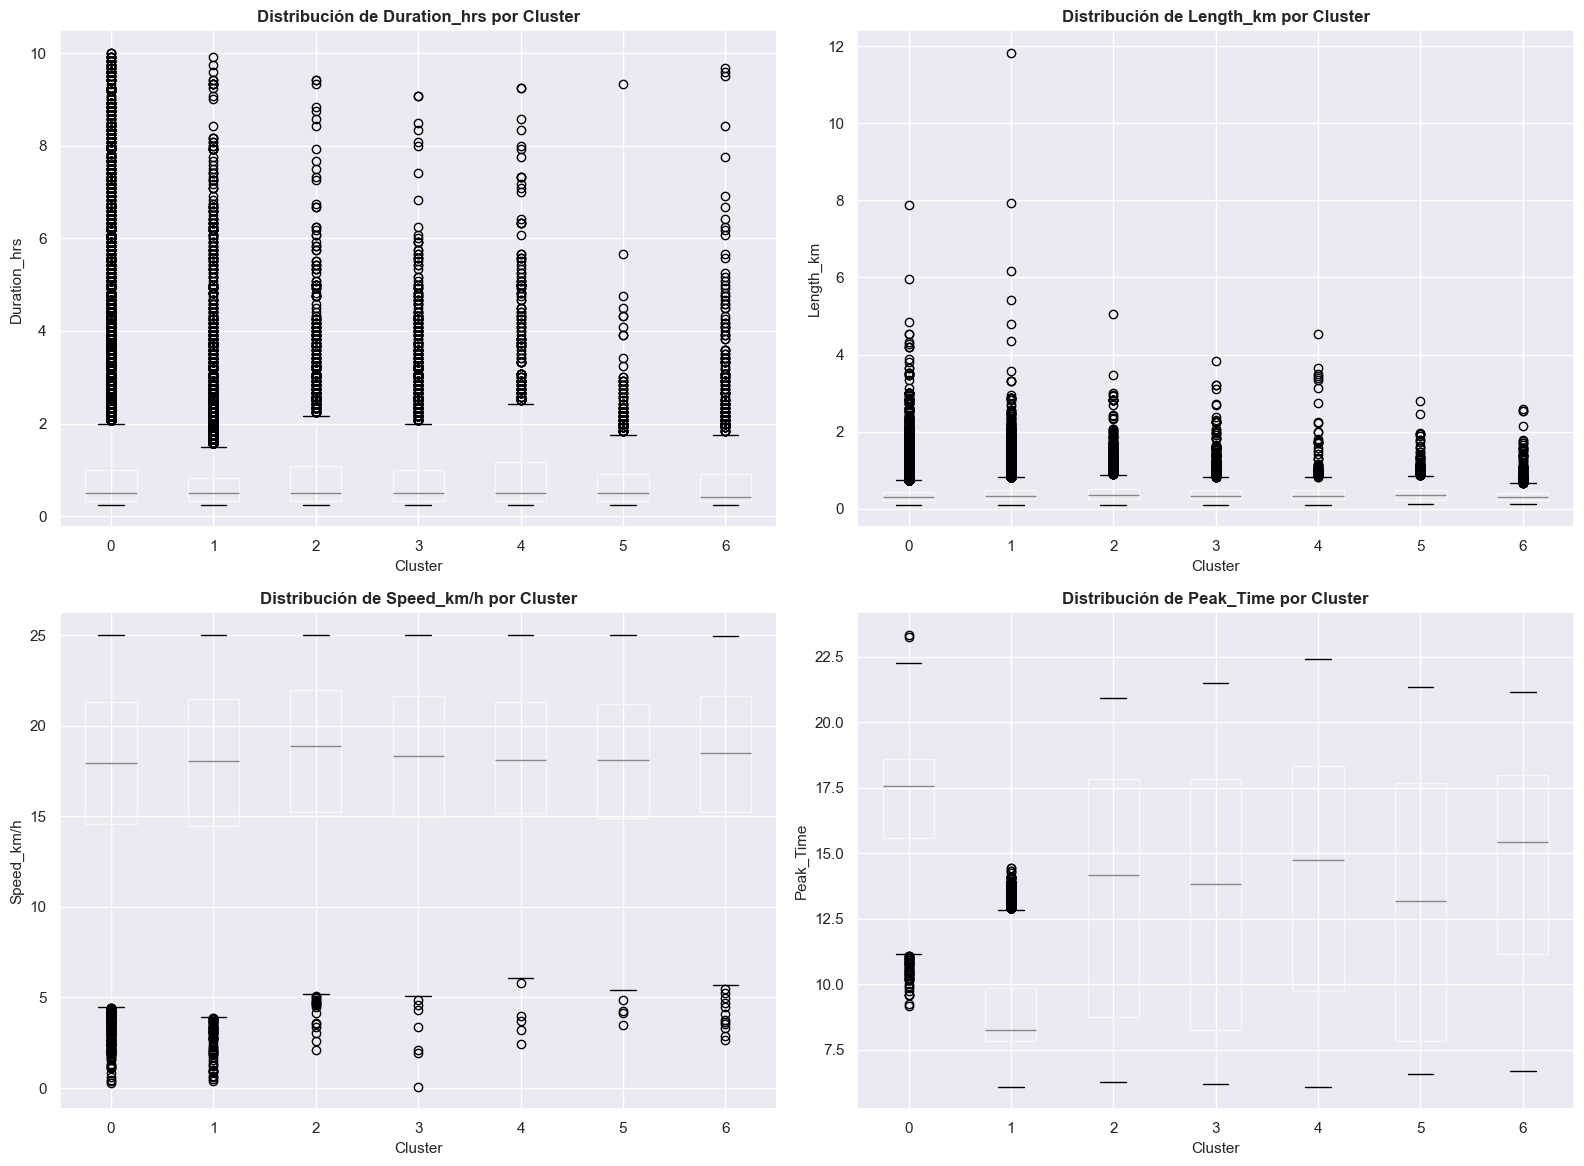

💡 Los boxplots muestran cómo se distribuyen las variables en cada cluster


In [13]:
# Boxplots de variables importantes
variables_analizar = ['Duration_hrs', 'Length_km', 'Speed_km/h', 'Peak_Time']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, var in enumerate(variables_analizar):
    df_resultado.boxplot(column=var, by='Cluster', ax=axes[i])
    axes[i].set_title(f'Distribución de {var} por Cluster', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Cluster', fontsize=11)
    axes[i].set_ylabel(var, fontsize=11)
    axes[i].get_figure().suptitle('')  # Remover título automático

plt.tight_layout()
plt.show()

print('💡 Los boxplots muestran cómo se distribuyen las variables en cada cluster')

### 6.2 Estadísticas descriptivas por cluster

In [14]:
# Estadísticas por cluster
print('ESTADÍSTICAS DESCRIPTIVAS POR CLUSTER')
print('='*80)

for var in variables_analizar:
    print(f'\n{var}:')
    print(df_resultado.groupby('Cluster')[var].describe().round(2))
    print('-'*80)

ESTADÍSTICAS DESCRIPTIVAS POR CLUSTER

Duration_hrs:
           count  mean   std   min   25%   50%   75%    max
Cluster                                                    
0        35829.0  0.92  1.13  0.25  0.33  0.50  1.00  10.00
1        25004.0  0.74  0.74  0.25  0.33  0.50  0.83   9.92
2         4967.0  0.87  0.91  0.25  0.33  0.50  1.08   9.42
3         5453.0  0.82  0.86  0.25  0.33  0.50  1.00   9.08
4         1784.0  0.97  1.16  0.25  0.33  0.50  1.17   9.25
5         1573.0  0.74  0.64  0.25  0.33  0.50  0.92   9.33
6         1530.0  0.85  1.02  0.25  0.33  0.42  0.92   9.67
--------------------------------------------------------------------------------

Length_km:
           count  mean   std   min   25%   50%   75%    max
Cluster                                                    
0        35829.0  0.38  0.28  0.10  0.23  0.31  0.43   7.87
1        25004.0  0.41  0.29  0.10  0.24  0.32  0.47  11.83
2         4967.0  0.44  0.30  0.10  0.26  0.35  0.51   5.06
3         5453

### 6.3 Visualización geográfica de clusters

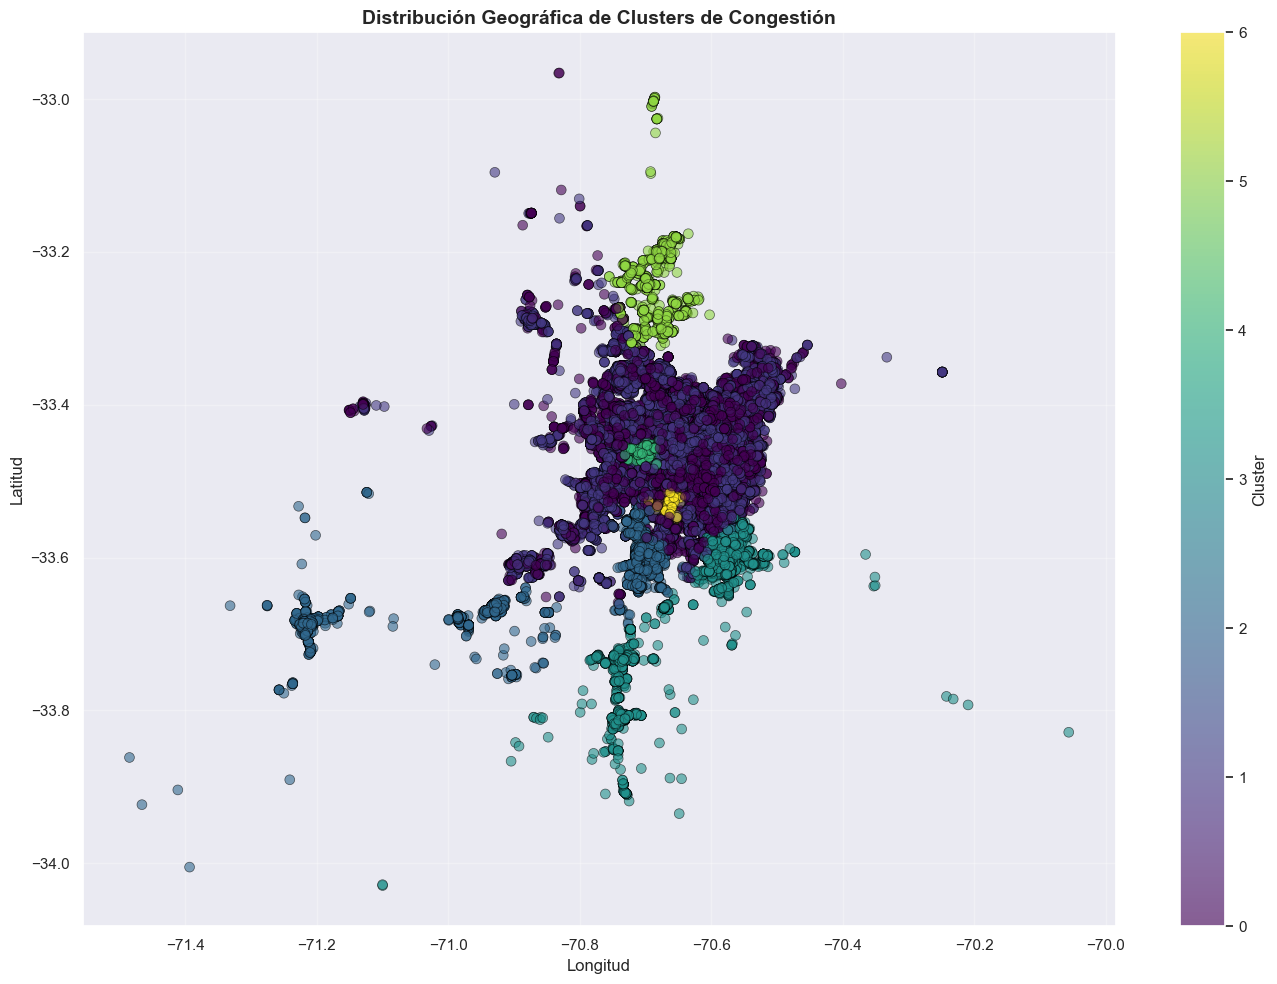

💡 Mapa muestra la distribución geográfica de los diferentes clusters de congestión


In [15]:
# Scatter plot de ubicación geográfica coloreado por cluster
plt.figure(figsize=(14, 10))
scatter = plt.scatter(df_resultado['Longitud'], 
                      df_resultado['Latitud'], 
                      c=df_resultado['Cluster'], 
                      cmap='viridis', 
                      alpha=0.6, 
                      s=50,
                      edgecolors='black',
                      linewidth=0.5)

plt.colorbar(scatter, label='Cluster')
plt.xlabel('Longitud', fontsize=12)
plt.ylabel('Latitud', fontsize=12)
plt.title('Distribución Geográfica de Clusters de Congestión', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('💡 Mapa muestra la distribución geográfica de los diferentes clusters de congestión')

### 6.4 Heatmap de características promedio por cluster

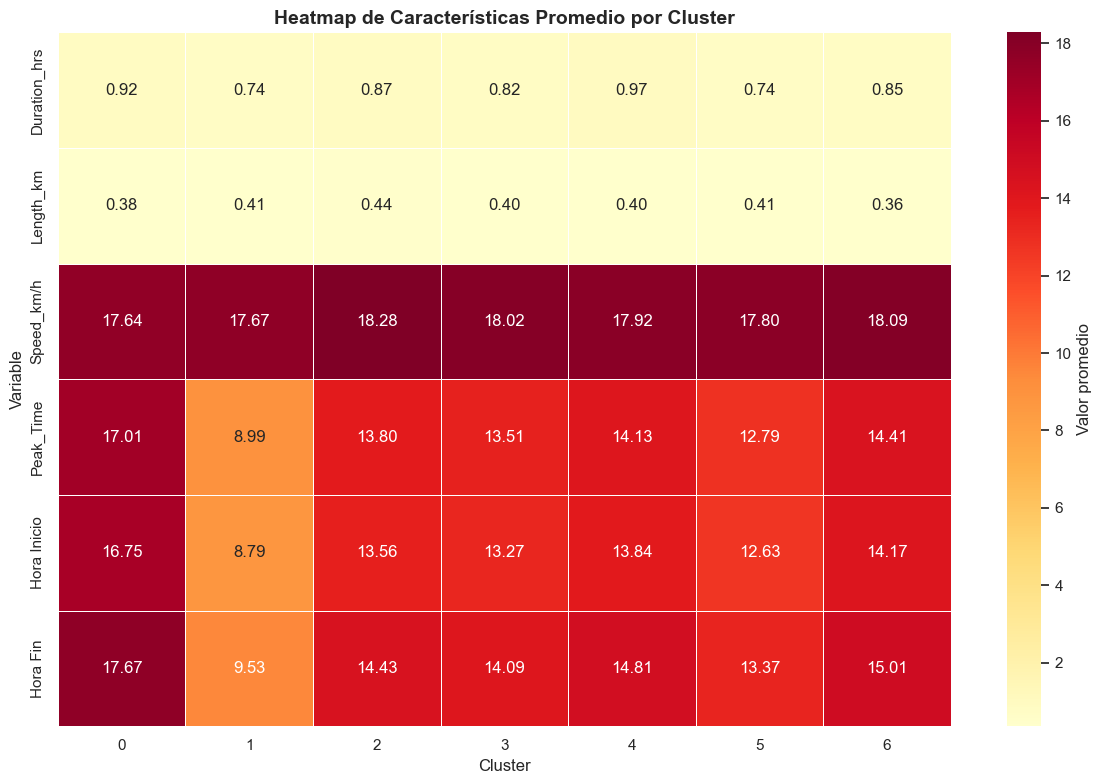

💡 El heatmap facilita la identificación de patrones en cada cluster


In [16]:
# Heatmap de características promedio
caracteristicas_clave = ['Duration_hrs', 'Length_km', 'Speed_km/h', 'Peak_Time', 'Hora Inicio', 'Hora Fin']
cluster_means = df_resultado.groupby('Cluster')[caracteristicas_clave].mean()

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means.T, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Valor promedio'}, linewidths=0.5)
plt.title('Heatmap de Características Promedio por Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.tight_layout()
plt.show()

print('💡 El heatmap facilita la identificación de patrones en cada cluster')

### 6.5 Análisis de silhouette por cluster

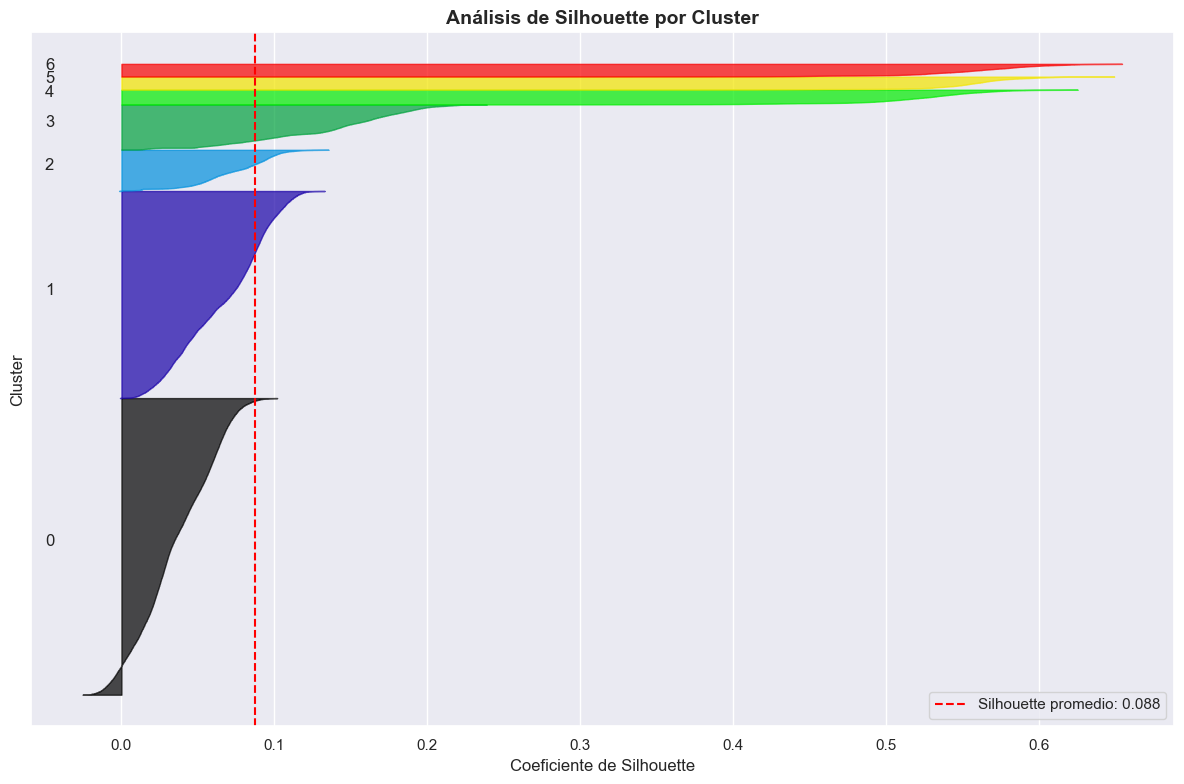

💡 Clusters con valores por encima del promedio están bien definidos


In [17]:
# Visualización detallada de silhouette
from matplotlib import cm

fig, ax = plt.subplots(figsize=(12, 8))

# Calcular valores de silhouette para cada muestra
silhouette_vals = silhouette_samples(df_scaled, clusters)

y_lower = 10
for i in range(K_OPTIMO):
    # Valores de silhouette para cluster i
    cluster_silhouette_vals = silhouette_vals[clusters == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / K_OPTIMO)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    # Etiqueta del cluster
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10

ax.set_title('Análisis de Silhouette por Cluster', fontsize=14, fontweight='bold')
ax.set_xlabel('Coeficiente de Silhouette', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)

# Línea vertical del promedio
ax.axvline(x=silhouette_final, color="red", linestyle="--", 
           label=f'Silhouette promedio: {silhouette_final:.3f}')
ax.legend()
ax.set_yticks([])
plt.tight_layout()
plt.show()

print('💡 Clusters con valores por encima del promedio están bien definidos')

## 7. Interpretación de Clusters

In [18]:
# Perfil de cada cluster
print('='*80)
print('PERFIL DE CADA CLUSTER')
print('='*80)

for cluster in range(K_OPTIMO):
    print(f'\n--- CLUSTER {cluster} ---')
    cluster_data = df_resultado[df_resultado['Cluster'] == cluster]
    
    print(f'Número de registros: {len(cluster_data)} ({len(cluster_data)/len(df_resultado)*100:.1f}%)')
    print(f'\nCaracterísticas principales:')
    print(f'  - Duración promedio: {cluster_data["Duration_hrs"].mean():.2f} hrs')
    print(f'  - Longitud promedio: {cluster_data["Length_km"].mean():.2f} km')
    print(f'  - Velocidad promedio: {cluster_data["Speed_km/h"].mean():.2f} km/h')
    print(f'  - Peak Time promedio: {cluster_data["Peak_Time"].mean():.2f}')
    
    # Comuna más frecuente
    if 'Commune' in cluster_data.columns:
        comuna_top = cluster_data['Commune'].mode()
        if len(comuna_top) > 0:
            print(f'  - Comuna más frecuente: {comuna_top.values[0]}')
    
    print('-'*80)

PERFIL DE CADA CLUSTER

--- CLUSTER 0 ---
Número de registros: 35829 (47.1%)

Características principales:
  - Duración promedio: 0.92 hrs
  - Longitud promedio: 0.38 km
  - Velocidad promedio: 17.64 km/h
  - Peak Time promedio: 17.01
  - Comuna más frecuente: Las Condes
--------------------------------------------------------------------------------

--- CLUSTER 1 ---
Número de registros: 25004 (32.8%)

Características principales:
  - Duración promedio: 0.74 hrs
  - Longitud promedio: 0.41 km
  - Velocidad promedio: 17.67 km/h
  - Peak Time promedio: 8.99
  - Comuna más frecuente: Santiago
--------------------------------------------------------------------------------

--- CLUSTER 2 ---
Número de registros: 4967 (6.5%)

Características principales:
  - Duración promedio: 0.87 hrs
  - Longitud promedio: 0.44 km
  - Velocidad promedio: 18.28 km/h
  - Peak Time promedio: 13.80
  - Comuna más frecuente: San Bernardo
-----------------------------------------------------------------------

In [19]:
# Guardar resultados
df_resultado.to_csv('../resultados/resultados_kmeans.csv', index=False)
print('✓ Resultados exportados a: ../resultados/resultados_kmeans.csv')

# Guardar centroides
centroides = pd.DataFrame(scaler.inverse_transform(kmeans_final.cluster_centers_), 
                          columns=df_clustering.columns)
centroides.to_csv('../resultados/centroides_clusters.csv', index=False)
print('✓ Centroides exportados a: ../resultados/centroides_clusters.csv')

✓ Resultados exportados a: ../resultados/resultados_kmeans.csv
✓ Centroides exportados a: ../resultados/centroides_clusters.csv


## 9. Conclusiones

### Resumen del análisis:

1. **Preparación de datos**: Se escalaron todas las variables numéricas usando StandardScaler

2. **Número óptimo de clusters**: Se determinó usando tres métodos:
   - Método del Codo (Elbow)
   - Silhouette Score
   - Gap Statistic

3. **Implementación**: Se aplicó K-Means con el número óptimo de clusters identificado

4. **Visualización**: Se generaron múltiples gráficos para interpretar los resultados:
   - Boxplots de variables clave
   - Distribución geográfica
   - Heatmap de características
   - Análisis de silhouette

### Interpretación:

Los clusters identificados representan diferentes patrones de congestión vehicular en Santiago, diferenciados por:
- Duración de la congestión
- Longitud del segmento congestionado
- Velocidad promedio
- Hora del día
- Ubicación geográfica

Esta segmentación permite identificar zonas y horarios críticos de congestión para implementar medidas de mitigación específicas.